# Regresión no lineal

Cuando el modelo es no lineal, ¿qué podemos hacer?

**Ejemplo:** En el caso de la combinación de $\sin$ y $\cos$ ya sabíamos la frecuencia, pero si la dejamos libre el modelo:

$$x_t = \beta_1 \cos(2\pi f t) + \beta_2 \sin(2\pi f t)$$

pasa a ser no lineal, con parámetros $\theta=(\beta_1,\beta_2,f)$.

**Ejemplo (Crecimiento logístico):** En estudio de poblaciones, muchas veces es útil ajustar un modelo de la forma:
$$f(t;\theta) = \frac{A}{1+e^{-b(t-t_0)}}$$
siendo los parámetros en este caso $\theta=(A,b,t_0)$.

In [1]:
## Ejemplo: instalación de astsadata usando pip:
#!pip install astsadata
#Importo astsadata
import warnings
with warnings.catch_warnings(action="ignore"):
    import astsadata as astsa

import numpy as np
import statsmodels.api as sm
## Ajusto tamaño de figuras
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15,5]
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.constrained_layout.use'] = True

## Idea: aplicar el mismo criterio de mínimos cuadrados

Es decir si tengo una función no lineal de los parámetros desconocidos $y_t(\theta)$, buscamos resolver:

$$\min_\theta \sum_{t=1}^n (x_t - y_t(\theta))^2$$

**Problema:** la optimización anterior no necesariamente es fácil de hacer. No hay garantías de convexidad, puede tener mínimos locales.

El algoritmo más utilizado para resolver el problema anterior es el de *Gauss-Newton* que converge a un mínimo local. Si tenemos una buena aproximación inicial de la solución converge.

En R, esto se hace mediante la función `nls`.

### Ejemplo:

Analicemos los ingresos a CTI por COVID en Uruguay en el período 15/3 -- 30/4.

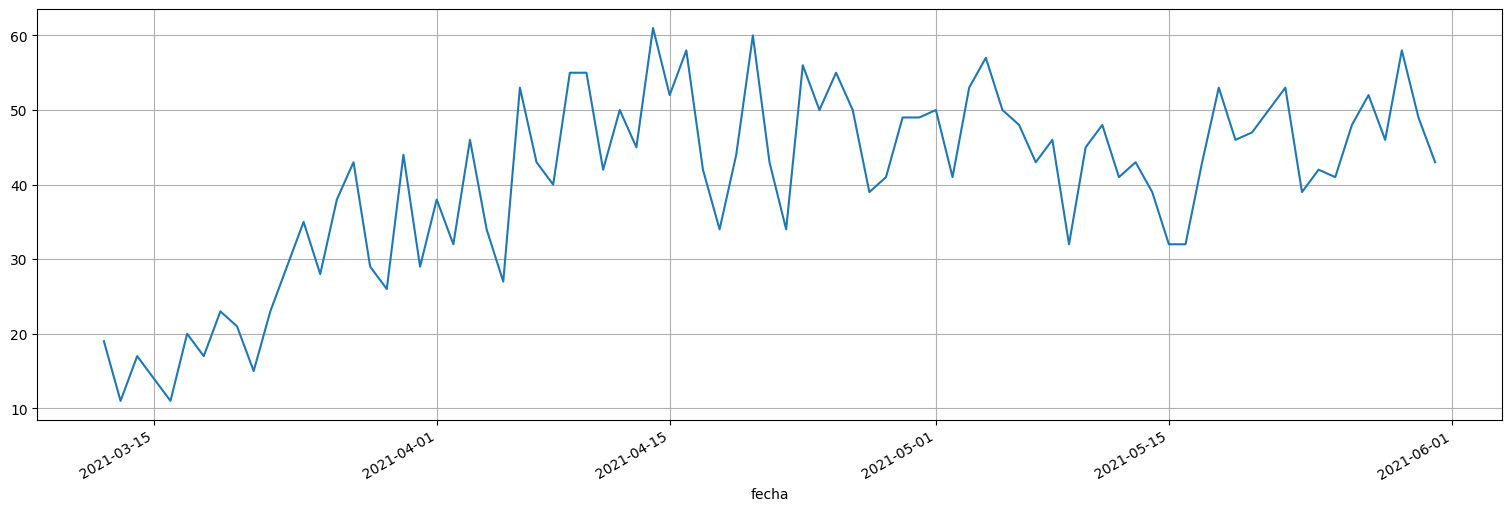

In [2]:
import pandas as pd
datos = pd.read_csv("https://raw.githubusercontent.com/GUIAD-COVID/datos-y-visualizaciones-GUIAD/master/datos/estadisticasUY_cti.csv", header=0,
                    index_col=[1], parse_dates=[1], date_format="%d/%m/%Y")
cti = datos["ingresos"].iloc[40:120]
cti.plot();

### Modelo:

Proponemos el siguiente modelo no lineal para ajustar una "meseta":

$$f(t,\theta) = a + b e^{-ct},$$

siendo $\theta = (a,b,c)$.

In [3]:
def f(theta, t):
    return theta[0] + theta[1]*np.exp(- theta[2] * t)

ts = np.arange(0,cti.size)
ys = cti.values

def residuos(theta):
    return f(theta, ts) - ys

In [4]:
from scipy.optimize import least_squares
theta0 = [50,-50,0.1]
fit = least_squares(residuos, theta0)

In [8]:
fit

     message: `ftol` termination condition is satisfied.
     success: True
      status: 2
         fun: [-1.095e+01  4.504e-02 ... -1.880e+00  4.126e+00]
           x: [ 4.720e+01 -3.915e+01  7.958e-02]
        cost: 2136.5518731435595
         jac: [[ 1.000e+00  1.000e+00  0.000e+00]
               [ 1.000e+00  9.235e-01  3.615e+01]
               ...
               [ 1.000e+00  2.015e-03  6.151e+00]
               [ 1.000e+00  1.860e-03  5.754e+00]]
        grad: [-5.691e-06 -2.108e-07  9.776e-01]
  optimality: 0.9776031482176677
 active_mask: [ 0.000e+00  0.000e+00  0.000e+00]
        nfev: 11
        njev: 11

In [9]:
a = fit.x[0]
b = fit.x[1]
c = fit.x[2]
loss = 2*fit.cost/ys.size

print("Coeficientes estimados:")
print(f"a = {a}")
print(f"b = {b}")
print(f"c = {c}")
print(f"Mean square error: {loss}")

Coeficientes estimados:
a = 47.19848397604239
b = -39.148174713716685
c = 0.07958170675096753
Mean square error: 53.413796828588985


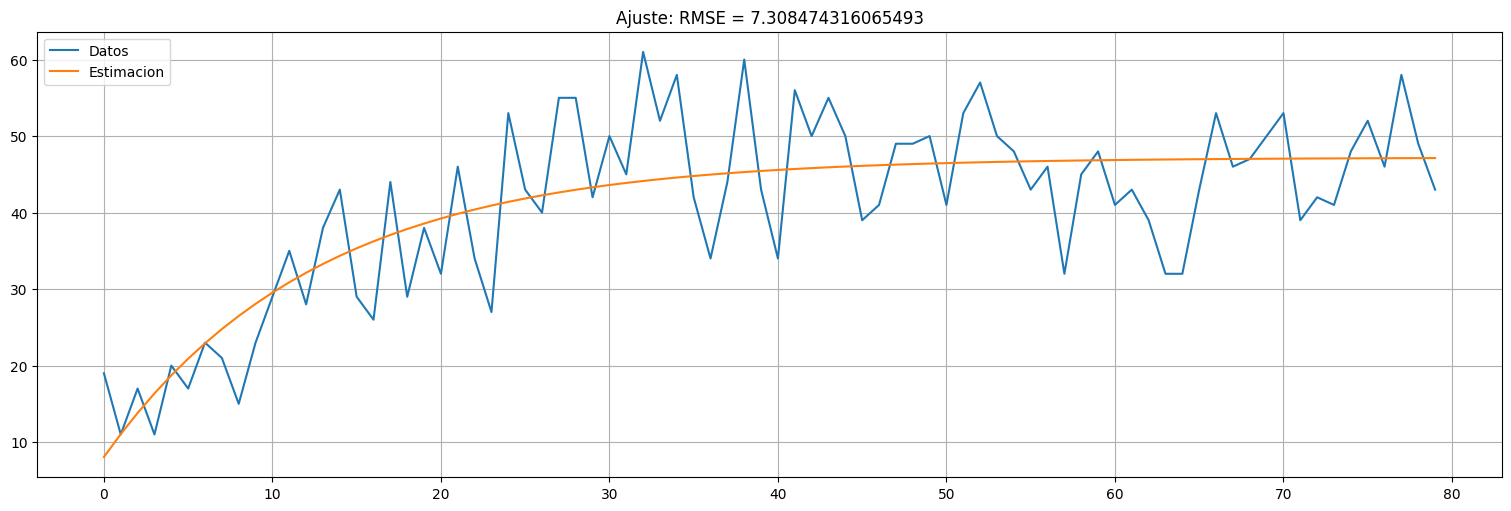

In [10]:
plt.plot(ts,ys, label="Datos");
plt.plot(ts,f(fit.x,ts), label="Estimacion")
plt.legend();
plt.title(f"Ajuste: RMSE = {np.sqrt(loss)}");

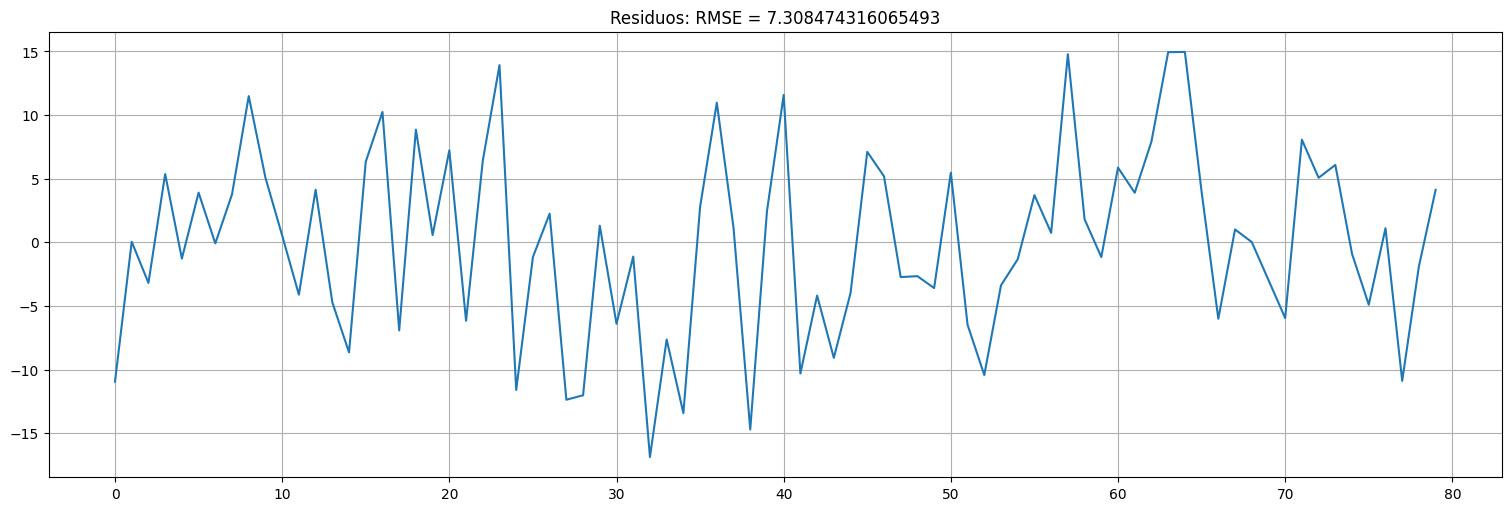

In [11]:
residuos = fit.fun
plt.plot(ts,residuos);
plt.title(f"Residuos: RMSE = {np.std(residuos)}"); #o bien sqrt(loss) debería dar lo mismo

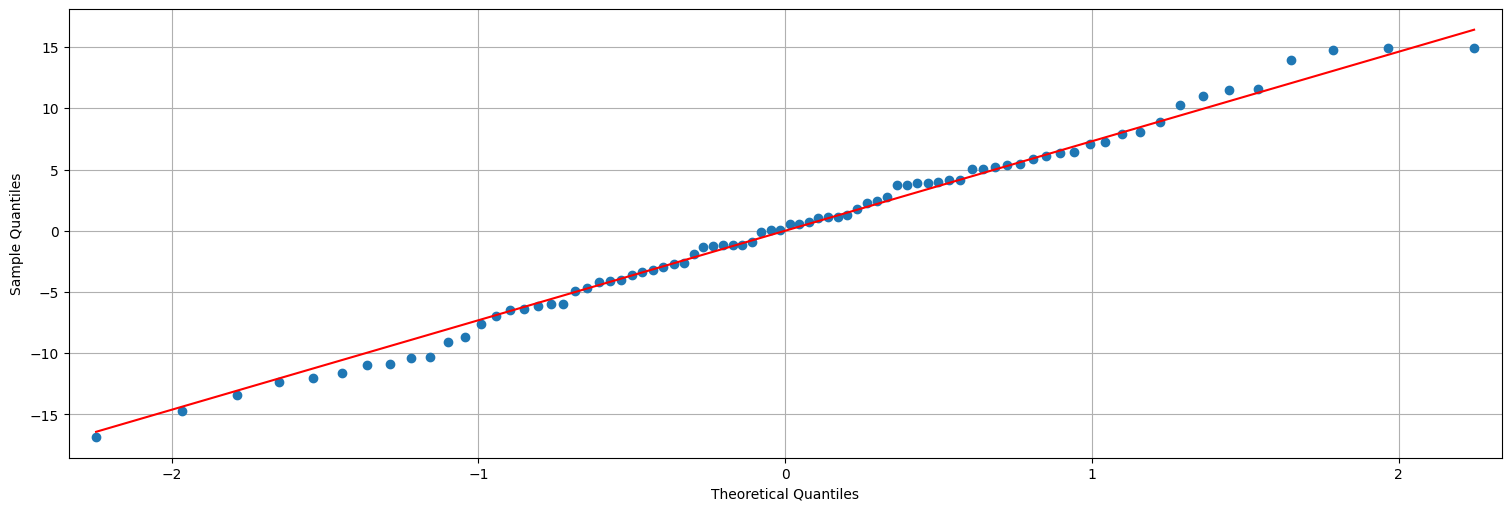

In [12]:
sm.qqplot(residuos, line="s");

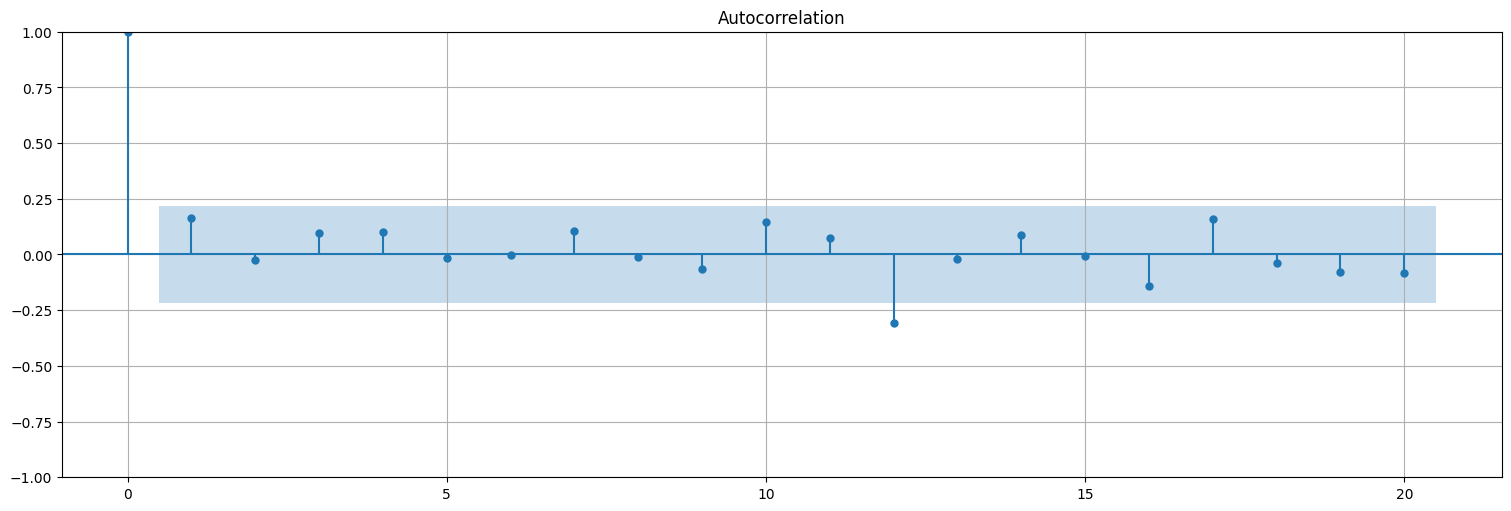

In [13]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(residuos, bartlett_confint=False);

In [14]:
#Calculo el R^2
n=cti.size

RSS = np.sum(residuos**2)/n
SSE = np.sum((cti-np.mean(cti))**2)/n
R2 = (SSE-RSS)/SSE

print(f"RSS = {RSS}");
print(f"SSE = {SSE}");
print(f"R2 = {R2}");


RSS = 53.413796828588985
SSE = 142.82734375
R2 = 0.6260254134384615


## Ejercicio

### Curva de población logística

Analizar el uso de la función `nls` para hacer una ajuste de curva logística a la serie de poblaciones de Australia entre 1778 y 2005 almacenada en `data/au_population.csv`.

La función logística de parámetros $A$, $b$ y $t_0$ tiene la siguiente expresión:

$$f(t;A,b,t_0) = \frac{A}{1+e^{-b(t-t_0)}}$$

Los parámetros representan:
* $A$: el valor asintótico.
* $b$: la velocidad de transición de $0$ a $A$.
* $t_0$: el tiempo de transición (donde vale $A/2$).


In [15]:
pop = pd.read_csv("../data/au_population.csv", header=0,
                    index_col=[0], parse_dates=[0], date_format="%Y")
pop = pop/1e6
pop.T

year,1788-01-01,1789-01-01,1790-01-01,1791-01-01,1792-01-01,1793-01-01,1794-01-01,1795-01-01,1796-01-01,1797-01-01,...,1996-01-01,1997-01-01,1998-01-01,1999-01-01,2000-01-01,2001-01-01,2002-01-01,2003-01-01,2004-01-01,2005-01-01
population,0.000859,0.000645,0.002056,0.002873,0.003264,0.003514,0.003579,0.003466,0.0041,0.004344,...,18.42032,18.609115,18.814276,19.038338,19.272644,19.533972,19.770963,20.011882,20.252132,20.544064


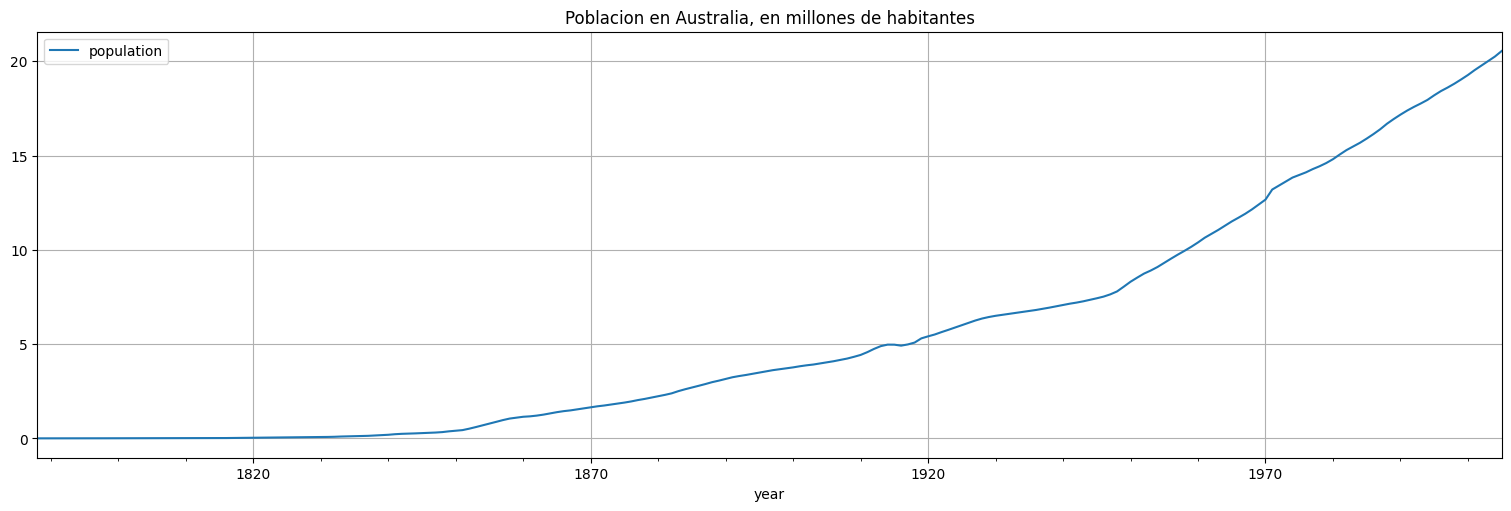

In [16]:
pop.plot(title="Poblacion en Australia, en millones de habitantes");